In [23]:
import boto3
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pathlib
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sagemaker.s3 import S3Downloader
from sagemaker.session import Session
import os
import numpy as np

In [14]:
! pip install pathlib

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
     |████████████████████████████████| 49 kB 5.8 MB/s  eta 0:00:01
  Created wheel for pathlib: filename=pathlib-1.0.1-py2-none-any.whl size=14347 sha256=4eb451ab440e154f0fbb3b70d21ee86514f91f66d98d6a3dd0eef03428d25ff5
  Stored in directory: /home/ec2-user/.cache/pip/wheels/46/37/4f/332bcea757140ff34e14dec7be65931f544c7ac94eb671ae9f
Successfully built pathlib


In [9]:
os.makedirs("./data")

In [10]:
sagemaker_session = Session()

def download_data_from_s3(s3_uri):
    S3Downloader.download(s3_uri=s3_uri,
                          local_path='./data/')

In [ ]:
download_data_from_s3('s3://kaggle-pawpularity-lorenz/')

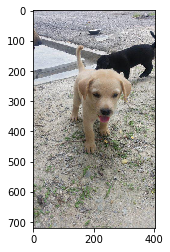

In [12]:
pic = load_img('data/0007de18844b0dbbb5e1f607da0606e0.jpg')
plt.imshow(pic)
plt.show()

In [16]:
train = pd.read_csv('csv/train.csv')

In [18]:
image_dir = Path('./data/')
filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
photo_id = pd.Series(filepaths.apply(lambda x : os.path.split(x)[1].split('.')[0]), name="Id")
images = pd.concat([filepaths, photo_id], axis=1)
train_img_path_df = pd.merge(train, images, on = 'Id', how = 'inner')
#image_5000 = train_img_path_df[['Pawpularity', 'Filepath']].sample(5000, random_state = 1).reset_index(drop = True)
train_df, test_df = train_test_split(train_img_path_df[['Pawpularity', 'Filepath']], train_size = 0.8, shuffle = True, random_state = 1)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p27/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2178: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [19]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)

In [20]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Pawpularity',
    target_size = (200, 200),
    color_mode = 'rgb',
    class_mode = 'raw',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
    )

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Pawpularity',
    target_size = (200, 200),
    color_mode = 'rgb',
    class_mode = 'raw',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
    )

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Pawpularity',
    target_size = (200, 200),
    color_mode = 'rgb',
    class_mode = 'raw',
    batch_size = 32,
    shuffle = False,
    )

Found 6342 validated image filenames.
Found 1585 validated image filenames.
Found 1982 validated image filenames.


In [21]:
inputs = tf.keras.Input(shape = (200, 200, 3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'linear')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'mse'
)

history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 50,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True
        )
    ]
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1/50
199/199 [==============================] - 140s 702ms/step - loss: 735.3721 - val_loss: 490.3516
Epoch 2/50
199/199 [==============================] - 134s 672ms/step - loss: 457.7132 - val_loss: 482.1106
Epoch 3/50
199/199 [==============================] - 134s 673ms/step - loss: 444.8164 - val_loss: 458.9971
Epoch 4/50
199/199 [==============================] - 135s 676ms/step - loss: 430.5350 - val_loss: 453.8592
Epoch 5/50
199/199 [==============================] - 136s 681ms/step - loss: 426.2062 - val_loss: 463.7037
Epoch 6/50
199/199 [==============================] - 134s 674ms/step - loss: 428.6996 - val_loss: 450.5378
Epoch 7/50
199/199 [==============================] - 136s 686ms/step - loss: 424.9856 - val_loss: 445.6088
Epoch 8/50
199/199 [==============================] - 135s 679ms/step - loss: 422.5113 - val_loss: 452.4982
Epoch 9/50
199/199 [==============================] - 1

In [24]:
predicted_score = np.squeeze(model.predict(test_images))
true_scores = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose = 0))
print(" Test RMSE: {:.5f}".format(rmse))

 Test RMSE: 20.72180


In [25]:
!git remote add origin https://github.com/sgtlm19/pawpularity-neural-net.git

fatal: remote origin already exists.


In [26]:
!git branch -M main

error: refname refs/heads/master not found
fatal: Branch rename failed


In [27]:
!git push -u origin main

error: src refspec main does not match any.
error: failed to push some refs to 'https://github.com/sgtlm19/pawpularity-neural-net.git'
